In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os
from importlib import reload

In [26]:
import dataset_utils
from glob import glob

In [27]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [28]:
bg_noise_dir = '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/data/03_09_2024_katie_pc_bg_noise/all_samples_merged.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [29]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            num_points_removed +=1
            points_removed.append(point)
    return filtered_data

In [30]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_train_points.append(bg_rm_arr)
                
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                # concatenated_train_points = background_subtraction(background_data, concatenated_train_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_test_points.append(bg_rm_arr)
                
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                # concatenated_test_points = background_subtraction(background_data, concatenated_test_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                
                test_points.append(sampled_data)
                test_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
                # print(test_labels)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [31]:
DATA_DIR = "data/3_09_2024_lab_pc_raw_data"
NUM_POINTS = 100
NUM_FRAMES = 3
NUM_CLASSES = 2
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: jumping
train_points shape: (151, 100, 5)
test_points shape: (39, 100, 5)
train_labels shape: (151,)
test_labels shape: (39,)


In [32]:
print(train_points)

[[[-5.908e-02  2.027e+00  1.296e+00  7.515e-01  2.520e+02]
  [ 4.008e+00  2.576e+00  4.834e-01  8.765e-01  1.590e+02]
  [ 3.844e+00  2.248e+00  1.411e+00  8.765e-01  1.320e+02]
  ...
  [-1.237e+00  5.352e-01  5.596e-01  0.000e+00  1.350e+02]
  [-1.237e+00  7.422e-01  1.074e-01  0.000e+00  1.400e+02]
  [-6.152e-02  2.055e+00  3.359e-01  3.757e-01  2.650e+02]]

 [[-5.908e-02  2.027e+00  1.296e+00  7.515e-01  2.520e+02]
  [-1.237e+00  7.500e-01  8.203e-02  0.000e+00  1.510e+02]
  [ 4.890e-01  2.520e+00  1.302e+00  5.010e-01  3.100e+02]
  ...
  [ 3.844e+00  2.248e+00  1.411e+00  8.765e-01  1.320e+02]
  [ 6.089e-01  2.045e+00  3.508e+00 -8.765e-01  2.160e+02]
  [ 2.109e-01  2.713e+00  1.322e+00  5.010e-01  2.880e+02]]

 [[ 4.890e-01  2.520e+00  1.302e+00  5.010e-01  3.100e+02]
  [ 1.729e-01 -8.984e-02  3.111e+00  0.000e+00  1.180e+02]
  [-7.324e-03  1.838e+00  1.242e+00  8.765e-01  2.480e+02]
  ...
  [ 3.499e-01  2.615e+00  1.359e+00  5.010e-01  2.920e+02]
  [-1.237e+00  5.742e-01  4.678e-0

In [33]:
print(test_points)

[[[ 3.2959e-01 -1.2891e-01  2.9824e+00  0.0000e+00  1.2100e+02]
  [ 1.5840e+00 -3.9062e-02  1.1836e+00  0.0000e+00  1.3800e+02]
  [-1.6797e-01  2.2910e+00  6.9629e-01  2.5049e-01  1.6500e+02]
  ...
  [ 1.5840e+00 -3.5156e-02  1.1680e+00  0.0000e+00  1.3900e+02]
  [ 1.5840e+00 -3.9062e-02  1.1836e+00  0.0000e+00  1.3800e+02]
  [ 1.7285e-01 -8.5938e-02  3.1328e+00  0.0000e+00  1.2400e+02]]

 [[ 3.2959e-01 -1.2891e-01  2.9824e+00  0.0000e+00  1.2100e+02]
  [ 1.5840e+00 -3.9062e-02  1.1836e+00  0.0000e+00  1.3800e+02]
  [-1.3955e+00  9.8242e-01 -1.6797e-01  0.0000e+00  1.3900e+02]
  ...
  [-8.2227e-01  1.8379e+00  7.0312e-01 -5.0098e-01  1.9800e+02]
  [ 1.5840e+00 -3.9062e-02  1.1836e+00  0.0000e+00  1.3800e+02]
  [-6.1816e-01  1.6914e+00  1.5430e+00 -6.2598e-01  2.3500e+02]]

 [[ 6.1182e-01  2.0254e+00  1.0859e+00  5.0098e-01  1.9100e+02]
  [ 4.6729e-01  2.2949e+00  1.4141e+00  7.5146e-01  2.9200e+02]
  [ 5.1367e-01  2.0020e+00  1.0547e+00  5.0098e-01  2.4700e+02]
  ...
  [-2.0898e-01  2.

In [34]:
# train_points = train_points[:, :, :3]
# test_points = test_points[:, :, :3]
print(CLASS_MAP)

{0: 'walking', 1: 'jumping'}


In [35]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [36]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [37]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn

In [38]:
inputs = keras.Input(shape=(NUM_POINTS, 5))

x = tnet(inputs, 5)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 100, 32)   │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 100, 64)   │      2,112 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 100, 512)  │     33,280 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_19[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 25)        │      3,225 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 5, 5)      │          0 │ dense_11[0][0]  

 Total params: 750,139 (2.86 MB)

 Trainable params: 744,059 (2.84 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [40]:
INIT_TIMESTAMP = "17_09_2024_pointnet_bg_rm"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [41]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [42]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback here
)

Epoch 1/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 69.6962 - sparse_categorical_accuracy: 0.5122
Epoch 1: val_loss improved from inf to 51.50766, saving model to model/checkpoints/17_09_2024_pointnet_bg_rm/best.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 65.6853 - sparse_categorical_accuracy: 0.5473 - val_loss: 51.5077 - val_sparse_categorical_accuracy: 0.6774
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 49.8323 - sparse_categorical_accuracy: 0.7969
Epoch 2: val_loss improved from 51.50766 to 37.65588, saving model to model/checkpoints/17_09_2024_pointnet_bg_rm/best.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 47.3278 - sparse_categorical_accuracy: 0.7981 - val_loss: 37.6559 - val_sparse_categorical_accuracy: 0.9355
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 40.9667 - sparse_categorical_accuracy: 0.8194
Epoch 3: val_loss improved from 37.65588 to 36.51087, saving model to model/checkpoints/17_09_2024_pointnet_bg_rm/best.weights.

In [43]:
from matplotlib import pyplot as plt

2024-09-17 12:43:00.671703: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
[[[-9.1797e-01  1.6777e+00  1.4023e+00  5.0098e-01  2.1000e+02]
  [-1.4014e+00  1.6875e+00  6.1426e-01  3.7573e-01  1.9200e+02]
  [ 4.6729e-01  2.2949e+00  1.4141e+00  7.5146e-01  2.9200e+02]
  ...
  [-2.0605e-01  1.5332e+00  1.1885e+00 -6.2598e-01  2.1300e+02]
  [ 1.2109e-01  1.6035e+00  6.7676e-01 -7.5146e-01  1.6800e+02]
  [ 1.5840e+00 -3.5156e-02  1.1729e+00  0.0000e+00  1.2700e+02]]

 [[ 6.1182e-01  2.0254e+00  1.0859e+00  5.0098e-01  1.9100e+02]
  [ 4.6729e-01  2.2949e+00  1.4141e+00  7.5146e-01  2.9200e+02]
  [ 5.1367e-01  2.0020e+00  1.0547e+00  5.0098e-01  2.4700e+02]
  ...
  [-2.0898e-01  2.3672e+00  3.6523e-01 -7.5146e-01  3.3000e+02]
  [-2.0898e-01  2.3672e+00  3.6523e-01 -7.5146e-01  3.3000e+02]
  [ 1.6113e-02 -4.2969e-02  3.2344e+00  0.0000e+00  1.2300e+02]]

 [[-8.8867e-01  2.1035e+00  3.2031e-01  0.0000e+00  1.2100e+02]
  [ 4.9438e-01  8.5938e-02  1.0000e+00  0.0000e+00  1.3000e+02]
  [ 2.4609e+00  5.3125e+00 -1.1562e+00 -7.5146e-0

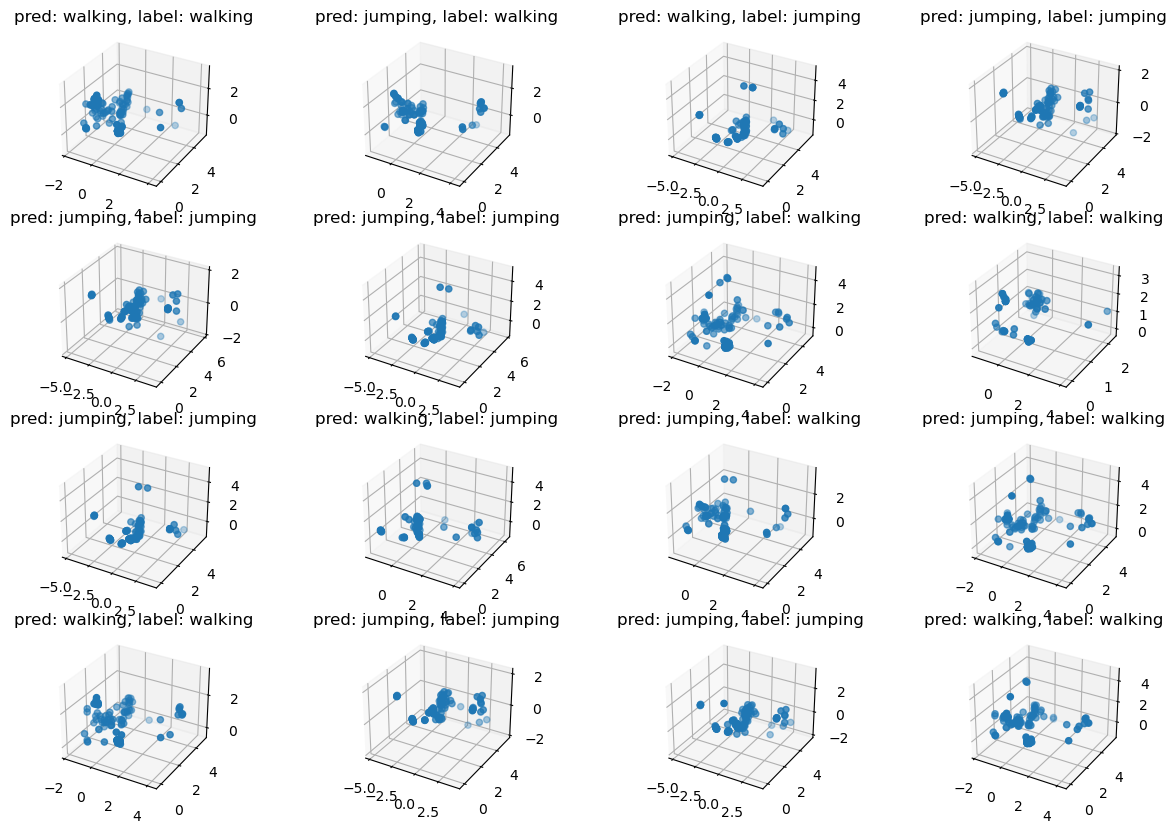

In [44]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [45]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [46]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 61.54%


In [47]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


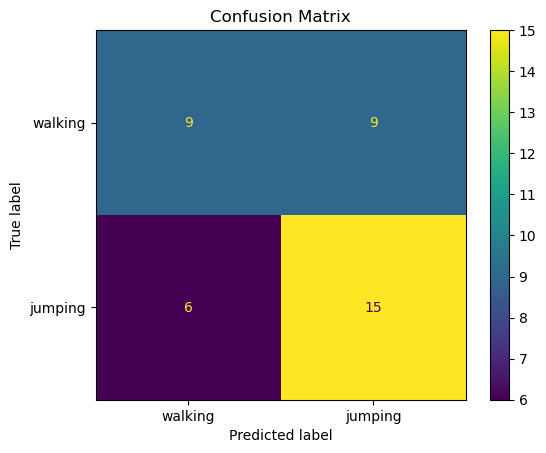

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking','jumping']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [37]:
#reload model
reload_model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
reload_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [38]:
reload_model.load_weights('model/checkpoints/2_09_2024/iter-20.weights.h5')

/Users/katiezhou/mambaforge/envs/py38/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 150 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
